In [1]:
import torch
from torch.utils.data import DataLoader
import os
import pandas as pd
from work.utils.dataset import PandasDataset, RGB2YHUTransform
from work.utils.models import EfficientNet
from work.utils.metrics import evaluation
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import albumentations

In [2]:
output_dimensions = 5
data_dir = '../../dataset'
images_dir = os.path.join(data_dir, 'tiles')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
df_test = pd.read_csv(f"../data/test.csv")
backbone_model = 'efficientnet-b0'
pretrained_model = {
    backbone_model: '../pre-trained-models/efficientnet-b0-08094119.pth'
}

In [3]:
print("Cuda", device)

Cuda cuda


In [4]:
val_transform =albumentations.Compose([
    RGB2YHUTransform()
])

In [5]:
dataloader = DataLoader(
    PandasDataset(images_dir, df_test, transforms=val_transform),
    batch_size=2,
    shuffle=False,
)

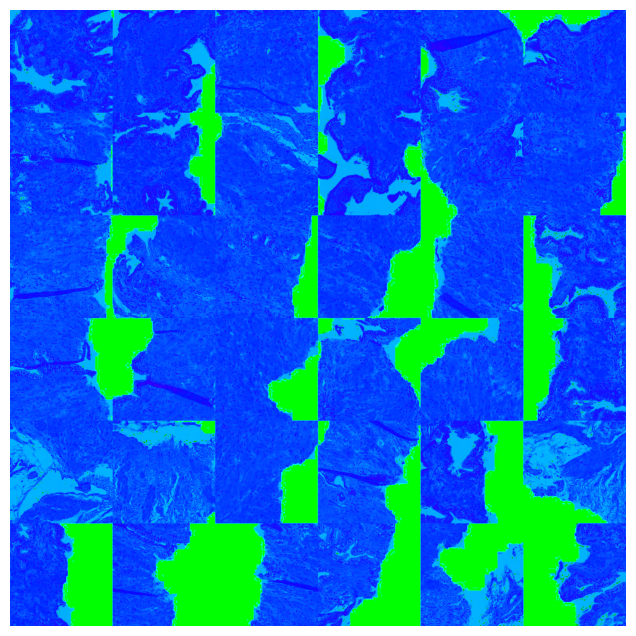

In [11]:
batch = next(iter(dataloader))
images, labels, _ = batch
plt.figure(figsize=(8, 8))
plt.imshow(torch.clamp(images[0], 0, 1).permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')
# plt.title(f'Label: {labels[0].item()}')
plt.savefig("YHU.png", dpi=300)
plt.show()


In [ ]:
model = EfficientNet(
    backbone=backbone_model,
    output_dimensions=output_dimensions,
    pre_trained_model=pretrained_model
)
model.to(device)
model.load_state_dict(
    torch.load(
        "models/with-noise-yhu.pth",
        weights_only=True
    )
)

response_0 = evaluation(model, dataloader, device)
print("without treatment", response_0[0])
cm_0 = confusion_matrix(response_0[1][1], response_0[1][0])

In [7]:
for idx, (true_class, pred_class, img_id) in enumerate(zip(response_0[1][1], response_0[1][0], response_0[1][2])):
    if true_class == 5 and pred_class in [0, 1, 2]:
        print(f"img_id com classe real 5 e classe predita {pred_class}: {img_id}")
    if true_class == 5 and pred_class == 5:
        print(f"img_id com classe real 5 e classe predita {pred_class}: {img_id}")

img_id com classe real 5 e classe predita 5.0: b48211c0c0fba52fcc8d919d03ed005b
img_id com classe real 5 e classe predita 5.0: 36eeee47a868b8ac66b6ece9e6372984
img_id com classe real 5 e classe predita 5.0: fec8271c64b26205d7fd0a18f2a1dedd
img_id com classe real 5 e classe predita 5.0: cf55f513b16209a90e3d71b1f5234c95
img_id com classe real 5 e classe predita 5.0: 6f8bf6cfb0c020fdfef1ddb79a250464
img_id com classe real 5 e classe predita 5.0: 7d3af9f4ccc93603028c8bcacf2d4dff
img_id com classe real 5 e classe predita 5.0: 464f8dbd8b906717dd1eb94a344f7262
img_id com classe real 5 e classe predita 5.0: 2daec36424a8f2afeaa4aad3d33a1589
img_id com classe real 5 e classe predita 5.0: 90a1a09e8b9543d69f9a90982ef5a789
img_id com classe real 5 e classe predita 5.0: eecf7d092d41484bdbb80ec95f49bb03
img_id com classe real 5 e classe predita 2.0: e19325ebb64adc3293f7173d7a337409
img_id com classe real 5 e classe predita 1.0: 5af447057c0eb2ca945c12c398f670f9
img_id com classe real 5 e classe predit

In [25]:
dataloader_clean = DataLoader(
    PandasDataset(images_dir, df_test[df_test["image_id"]=="5af447057c0eb2ca945c12c398f670f9"]),
    batch_size=2,
    shuffle=False
)
model = EfficientNet(backbone="efficientnet-b0", output_dimensions=output_dimensions)
model.to(device)
model.load_state_dict(
    torch.load(
        "pre-trained-models/without-noise-rgb.pth",
        weights_only=True,
        map_location=device
    )
)

response_1_1 = evaluation(model, dataloader_clean, device)
print("with remove images", response_1_1[0])
cm_1 = confusion_matrix(response_1_1[1][1], response_1_1[1][0])

Loaded pretrained weights for efficientnet-b0


100%|██████████| 1/1 [00:00<00:00, 17.35it/s]

with remove images {'val_acc': 0.0, 'kappa': 0.0}


In [6]:
for idx, (true_class, pred_class, img_id) in enumerate(zip(response_1_1[1][1], response_1_1[1][0], response_1_1[1][2])):
    if true_class == 5 and pred_class in [0, 1, 2]:
        print(f"img_id com classe real 5 e classe predita {pred_class}: {img_id}")
    if true_class == 5 and pred_class == 5:
        print(f"img_id com classe real 5 e classe predita {pred_class}: {img_id}")

NameError: name 'response_1_1' is not defined

In [12]:
model = EfficientNet(backbone="efficientnet-b0", output_dimensions=output_dimensions)
dataloader = DataLoader(
    PandasDataset(
        images_dir,
        df_test,
        transforms=RemovePenMarkAlbumentations()
    ),
    batch_size=2,
    shuffle=False
)
model.to(device)
model.load_state_dict(
    torch.load(
        "pre-trained-models/fold_03_30_epochs_penmark_certo.pth",
        weights_only=True,
        map_location=device
    )
)

response_2 = evaluation(model, dataloader, device)
print("clean only marks", response_2[0])
cm_2 = confusion_matrix(response_2[1][1], response_2[1][0])

Loaded pretrained weights for efficientnet-b0


100%|██████████| 796/796 [04:04<00:00,  3.25it/s]

clean only marks {'val_acc': 53.266331658291456, 'kappa': 0.7625038275395726}


In [29]:
clean_dict = {
    "target": [],
    "pred": [],
    "image_id": []
}
for idx, (true_class, pred_class, img_id) in enumerate(zip(response_2[1][1], response_2[1][0], response_2[1][2])):
    clean_dict["target"].append(true_class)
    clean_dict["pred"].append(pred_class)
    clean_dict["image_id"].append(img_id)

df_predict_clean = pd.DataFrame(data=clean_dict)

df_predict_clean.to_csv("data/predict_clean.csv")


In [42]:
print(cm_0, cm_1, cm_2)

[[149 178  72  26   7   2]
 [ 56 184 125  28   7   0]
 [  2  45  76  50  20   8]
 [  2   4  25  42  69  44]
 [  2   7  20  16  67  75]
 [  0   2   5  13  45 119]] [[375  37  10   9   3   0]
 [ 37 307  44  12   0   0]
 [  4  44 101  41   9   2]
 [  4   7  32  82  55   6]
 [  2  10   8  30 106  31]
 [  3   5   4  18  60  94]] [[373  40  15   4   2   0]
 [145 178  73   4   0   0]
 [ 41  41  78  36   3   2]
 [ 16  14  26  66  55   9]
 [ 18  23  20  19  65  42]
 [ 10  12   8  13  53  88]]


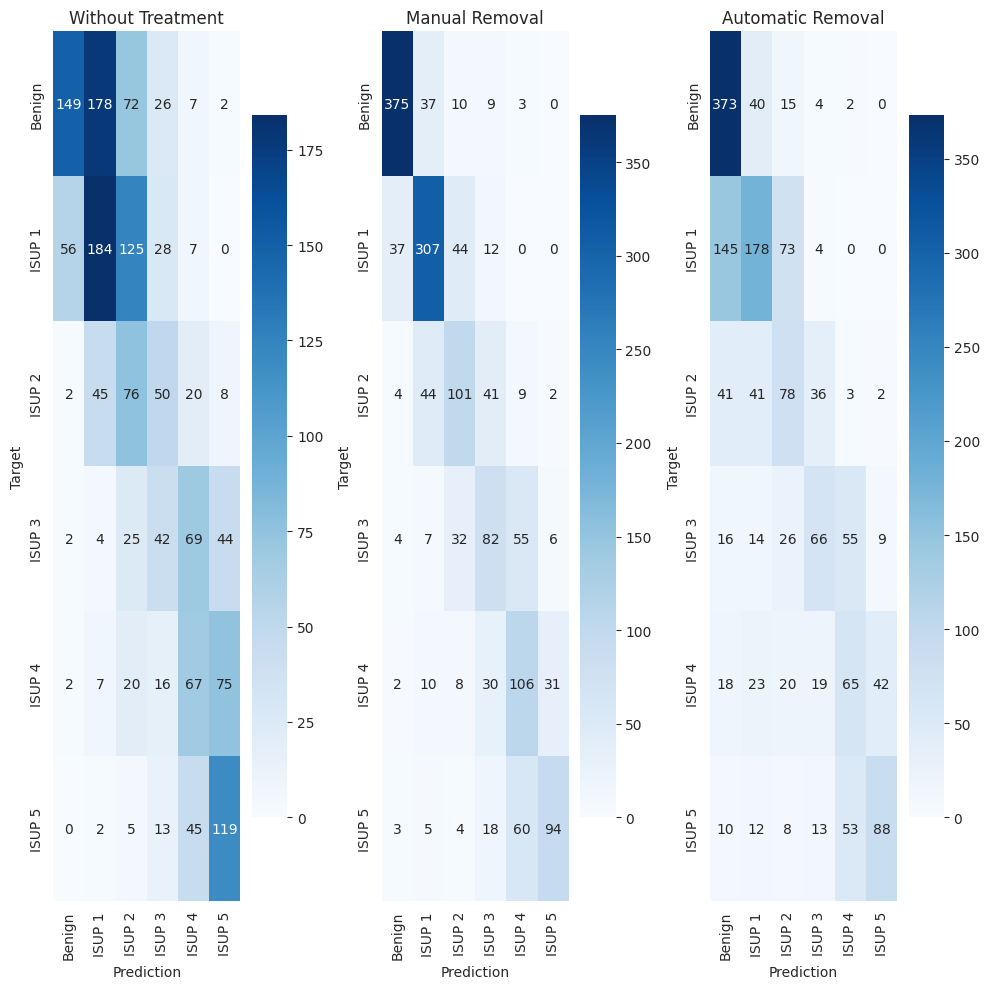

In [38]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(1, 3)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

# Labels
labels = ["Benign", "ISUP 1", "ISUP 2", "ISUP 3", "ISUP 4", "ISUP 5"]

# Criando os heatmaps
sns.heatmap(cm_0, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax0)
ax0.set_xlabel("Prediction")
ax0.set_ylabel("Target")
ax0.set_title("Without Treatment")

sns.heatmap(cm_1, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax1)
ax1.set_xlabel("Prediction")
ax1.set_ylabel("Target")
ax1.set_title("Manual Removal")

sns.heatmap(cm_2, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax2)
ax2.set_xlabel("Prediction")
ax2.set_ylabel("Target")
ax2.set_title("Automatic Removal")

plt.tight_layout()

plt.savefig("confusion_matrix.png", dpi=300)

plt.show()

In [39]:
import numpy as np
def kappa_per_class(cm):
    num_classes = cm.shape[0]
    total_samples = np.sum(cm)

    kappas = []
    for i in range(num_classes):
        po = cm[i, i] / np.sum(cm[i, :])
        pe = (np.sum(cm[:, i]) * np.sum(cm[i, :])) / (total_samples ** 2)
        kappa = (po - pe) / (1 - pe) if (1 - pe) != 0 else 1.0
        kappas.append(kappa)

    return kappas

In [40]:
print(kappa_per_class(cm_0))

[0.318701636780475, 0.421664322803981, 0.3617602607204742, 0.2157341629570981, 0.34794501665817895, 0.6402621966762967]


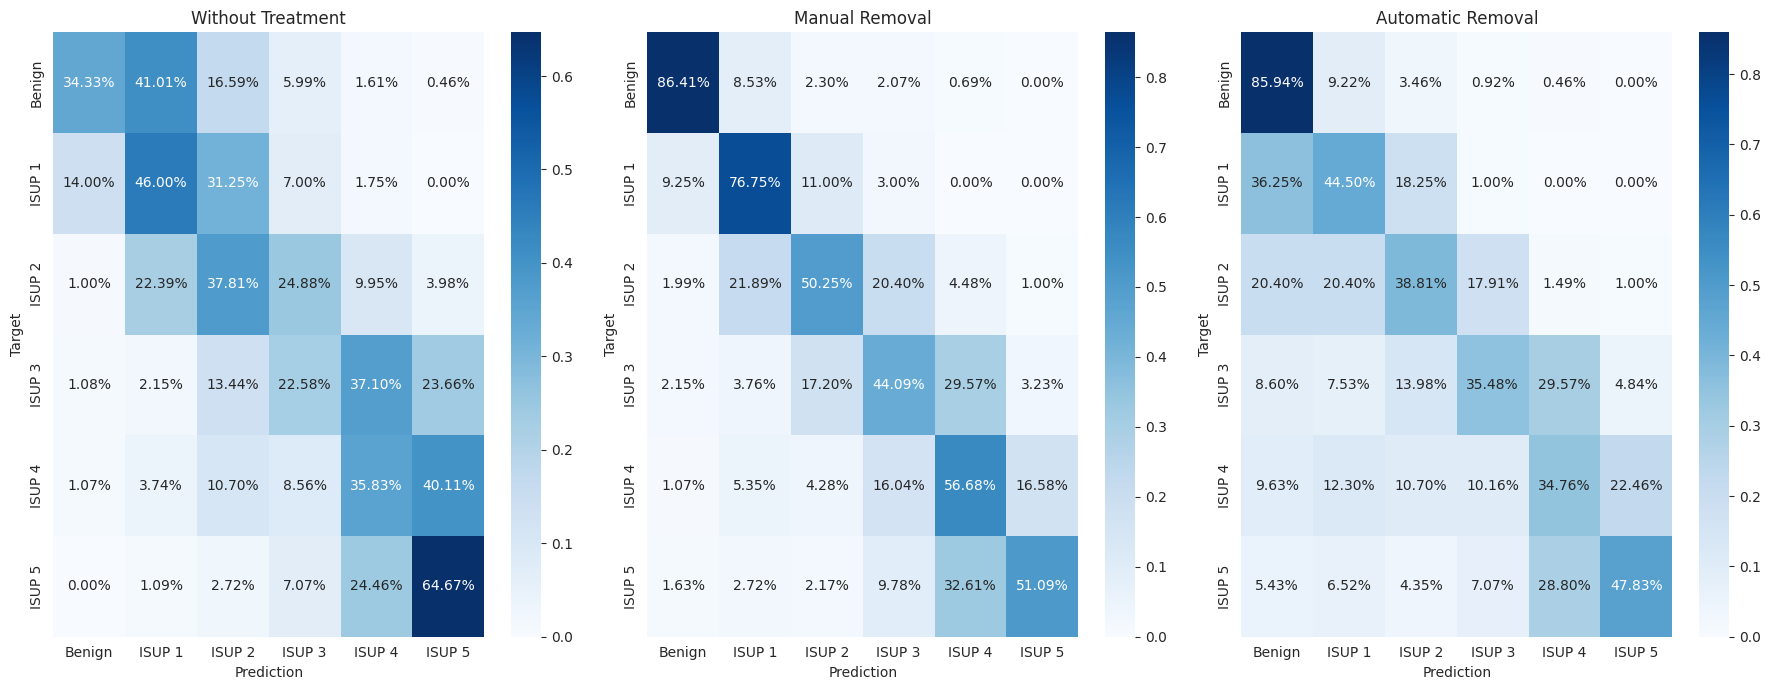

In [41]:
# Criação da figura com gridspec para controlar o layout
fig = plt.figure(figsize=(18, 7))
gs = fig.add_gridspec(1, 3)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

# Labels
labels = ["Benign", "ISUP 1", "ISUP 2", "ISUP 3", "ISUP 4", "ISUP 5"]

sns.heatmap(cm_0/cm_0.sum(axis=1, keepdims=True), fmt=".2%", annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax0)
ax0.set_xlabel("Prediction")
ax0.set_ylabel("Target")
ax0.set_title("Without Treatment")

sns.heatmap(cm_1/cm_1.sum(axis=1, keepdims=True), fmt=".2%", annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax1)
ax1.set_xlabel("Prediction")
ax1.set_ylabel("Target")
ax1.set_title("Manual Removal")

sns.heatmap(cm_2/cm_2.sum(axis=1, keepdims=True), fmt=".2%", annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax2)
ax2.set_xlabel("Prediction")
ax2.set_ylabel("Target")
ax2.set_title("Automatic Removal")

plt.tight_layout()

plt.savefig("confusion_matrix.png", dpi=300)
plt.show()